In [2]:
from time import time
import pandas as pd
import numpy as np
from PIL import Image
import keras.layers.advanced_activations
import scipy
import random
import matplotlib.pyplot as plt  
from scipy.stats import norm  
import keras
from keras.models import Sequential
from keras.initializers import VarianceScaling,RandomNormal
from keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D,concatenate
from keras.layers import UpSampling2D, Reshape, Lambda, Flatten, Activation,Concatenate
from keras.models import Model  
from keras.optimizers import SGD, Adadelta, Adagrad,Adam
from keras import backend as K  
from keras import objectives  
from keras.utils.vis_utils import plot_model  
from keras.utils import np_utils, generic_utils
import sys 
import tensorflow as tf
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.layers import BatchNormalization
from keras.layers.normalization import BatchNormalization
import matplotlib.pyplot as plt
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import sklearn
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter
%matplotlib inline
from sklearn import manifold, datasets,cluster
from sklearn.utils import check_random_state
from sklearn import metrics

Using TensorFlow backend.


In [3]:
path = os.listdir('Unlabel_data_100k/')
Image = []
for i in range(len(path)):
    path_now = path[i]
    a = np.load('Unlabel_data_100k/'+str(path_now))
    Image.append(a)

Image = np.asarray(Image)
Image_RGB = Image.transpose(0,2,3,1)
for i in range(len(Image_RGB)):
    if True in np.isnan(Image_RGB[i]).reshape(64*64*5):
        print(i)
        Image_RGB[i][np.isnan(Image_RGB[i])==True]=np.mean(Image_RGB[0])
#show_Image_RGB = (Image_RGB - np.min(Image_RGB))/(np.max(Image_RGB) - np.min(Image_RGB))*2 - np.ones_like(Image_RGB)
#Image_RGB -= np.mean(Image_RGB)
#Image_RGB /= np.std((Image_RGB))


Image_RGB /= np.max(Image_RGB)
Image_RGB -= np.mean(Image_RGB)
Image_RGB = -Image_RGB
data = Image_RGB
index = [i for i in range(len(data))]
#random.shuffle(index)
train_data = data[index]
print('train_data.shape:',train_data.shape)


25103
51048
64260
train_data.shape: (100000, 64, 64, 5)


In [4]:
batch_size =100
latent_dim = 30
nb_epoch = 50
intermediate_dim =512
original_dim = 64*64
LRelu = keras.layers.advanced_activations.LeakyReLU(alpha=0.3)

USE = 'autoencoder'
#USE = 'vae'
#encoder:

input_img = Input(shape=(64,64,5))

conv_1 = Conv2D(40, (3, 3), padding='same',kernel_initializer='normal')(input_img)
conv_1 = Activation(LRelu)(conv_1)
conv_1 = BatchNormalization()(conv_1)
maxpool_1 = MaxPooling2D((2, 2),padding='same')(conv_1)

conv_2 = Conv2D(40, (3, 3), padding='same',kernel_initializer='normal')(maxpool_1)
conv_2 = Activation(LRelu)(conv_2)
conv_2 = BatchNormalization()(conv_2)
maxpool_2 = MaxPooling2D((2, 2),  padding='same')(conv_2)

conv_3 = Conv2D(20, (3, 3),padding='same',kernel_initializer='normal')(maxpool_2)
conv_3 = Activation(LRelu)(conv_3)
conv_3 = BatchNormalization()(conv_3)
maxpool_3 = MaxPooling2D((2, 2),  padding='same')(conv_3)

conv_4 = Conv2D(20, (3, 3),padding='same',kernel_initializer='normal')(maxpool_3)
conv_4 = Activation(LRelu)(conv_4)
conv_4 = BatchNormalization()(conv_4)
maxpool_4 = MaxPooling2D((2, 2),  padding='same')(conv_4)

#conv_5 = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(maxpool_4)
#maxpool_5 = MaxPooling2D((2, 2),  padding='same')(conv_5)


#x = Conv2D(5, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
#x = MaxPooling2D((2, 2),  padding='same')(x)

visual = Flatten()(maxpool_4)
h_1 = Dense(intermediate_dim, activation='relu')(visual)#relu?
encoded = Dense(latent_dim, activation='tanh')(h_1)# relu?


if USE == 'autoencoder':
    h_3 = Dense(intermediate_dim,activation=LRelu)(encoded)#for AE
    
    
h_4 = Dense(20*4*4,activation=LRelu)(h_3)
h_5 = Reshape((4,4,20))(h_4)


#conv_6 = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(h_5)
#upsample_6 = UpSampling2D((2, 2))(conv_6)

#conv_7 = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(h_5)
upsample_7 = UpSampling2D((2, 2))(h_5)

conv_8 = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(upsample_7)
upsample_8 = UpSampling2D((2, 2))(conv_8)

conv_9 = Conv2D(40, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(upsample_8)
upsample_9 = UpSampling2D((2, 2))(conv_9)

conv_10 = Conv2D(80,  (3, 3), activation='relu',padding='same',kernel_initializer='normal')(upsample_9)
upsample_10 = UpSampling2D((2, 2))(conv_10)

decoded = Conv2D(5, (3, 3), activation='tanh', padding='same')(upsample_10)


EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')


#def vae_loss(x, decoded):  
#    xent_loss = K.sum(K.sum(objectives.binary_crossentropy(x ,decoded),axis=-1),axis=-1)
#    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) 
#    return xent_loss + 1*kl_loss  

def ae_loss(x, decoded):  
    xent_loss = original_dim * objectives.mean_squared_error(x,decoded)
    return xent_loss

if USE == 'autoencoder':
    autoencoder = Model(inputs=input_img, outputs=decoded)
    autoencoder.compile(optimizer='rmsprop', loss=ae_loss)

/home/sunhao/anaconda3/lib/python3.6/site-packages/keras/activations.py:103: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  ).format(identifier=identifier.__class__.__name__))


In [5]:
autoencoder.load_weights('hennanxunliande.h5')

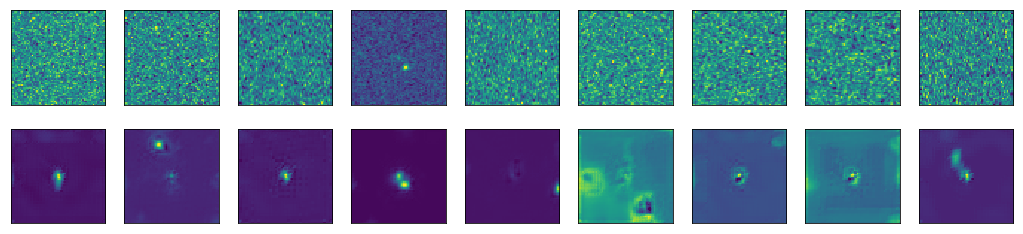

In [6]:
decoded_imgs = autoencoder.predict(train_data[0:100],batch_size=100)

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2,n,i)
    plt.imshow((train_data[0:100][i][:,:,0]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n ,i + n)
    plt.imshow((decoded_imgs[i][:,:,0]))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [7]:
encoder = Model(inputs=input_img, outputs=encoded)
encoded_variables = encoder.predict(train_data[:100000],batch_size=100)
encoded_variables.shape

(100000, 30)

In [8]:
Zero_one_normalized_encoded_variables = encoded_variables#/np.std(encoded_variables)/2

In [9]:
path = os.listdir('SDSS_20k/')

test_Image = []
Class = []
Object_ID = []
for i in range(len(path)):
    path_now = path[i]
    a = np.load('SDSS_20k/'+str(path_now))
    for j in range(a.shape[0]):
        test_Image.append(a[j]['image'])
        Class.append(a[j]['class'])
        Object_ID.append(a[j]['objID'])

test_Image = np.asarray(test_Image)
Class = np.asarray(Class)
Object_ID = np.asarray(Object_ID)
Class[Class=='STAR'] = 0
Class[Class=='GALAXY'] = 1
Class[Class=='QSO'] = 2
Class = Class.astype(int)

test_Image_RGB = test_Image.transpose(0,2,3,1)

for i in range(len(test_Image_RGB)):
    if True in np.isnan(test_Image_RGB[i]).reshape(64*64*5):
        print(i)
        test_Image_RGB[i][np.isnan(test_Image_RGB[i])==True]=np.mean(test_Image_RGB[0])
#show_Image_RGB = (Image_RGB - np.min(Image_RGB))/(np.max(Image_RGB) - np.min(Image_RGB))*2 - np.ones_like(Image_RGB)
#Image_RGB -= np.mean(Image_RGB)
#Image_RGB /= np.std((Image_RGB))


test_Image_RGB /= np.max(test_Image_RGB)
test_Image_RGB -= np.mean(test_Image_RGB)
test_Image_RGB = -test_Image_RGB

872
15249
32951
37233
37879
45552
63104
63918
72767
81185
88285
96972
101023
122609


/home/sunhao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
/home/sunhao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
/home/sunhao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


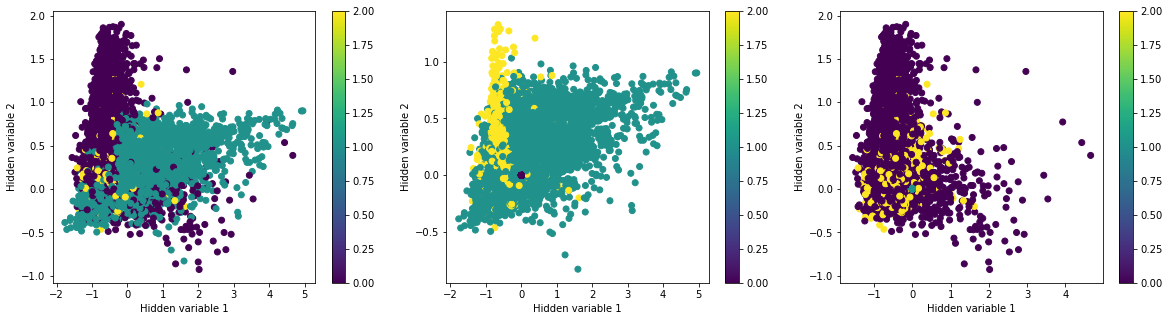

1019
0.904238418135


In [10]:
AUC = np.zeros((1,))

for xunhuan in range(1):
    """VAE"""
    net_3_input= Input(shape=(30,))
    h_1 = Dense(30, activation='tanh')(net_3_input)

    z_mean = Dense(1)(h_1)
    z_log_var = Dense(1)(h_1)
    z_mean_2 = Dense(1)(h_1)
    z_log_var_2 = Dense(1)(h_1)
    z_mean_con = Concatenate()([z_mean,z_mean_2])
    def sampling1d(args):   
        z_mean, z_log_var = args  
        epsilon = K.random_normal(shape=(100, 1), mean=0.,stddev=0.1)
        return z_mean + K.exp(z_log_var / 2)* epsilon
    def sampling5d(args):   
        z_mean, z_log_var = args  
        epsilon = K.random_normal(shape=(100, 1), mean=0.,stddev=0.1)
        return z_mean + K.exp(z_log_var / 2)* epsilon
    
    z = Lambda(sampling1d, output_shape=(1,))([z_mean, z_log_var])
    z_2 = Lambda(sampling5d, output_shape=(1,))([z_mean_2, z_log_var_2])
    z_con = Concatenate()([z,z_2])
    decoded = Dense(30, activation='tanh')(z_con)

    def vae_loss(x, decoded):
        xent_loss = K.sum((objectives.mse(x ,decoded)),axis=-1)
        #kl_loss_d1 = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) 
        m = K.constant(0)
        s = K.constant(1)
        #kl_loss_d1 = K.sum(K.log(2/K.exp(z_log_var/2))+(K.square(z_mean)+(K.exp(z_log_var/2)-K.constant(1))*(K.exp(z_log_var/2)+K.constant(1)))/(K.constant(2)),axis = -1)
        kl_loss_d1 = K.sum(K.log(2*s/K.exp(z_log_var/2))+(K.constant(2)*m*(-K.exp(-(K.square(z_mean))/((K.constant(2))*K.exp(z_log_var)))*K.exp(z_log_var/2) + K.sqrt(K.constant(np.pi/2))*z_mean*(K.constant(1)-K.tanh(K.constant(1.19)*z_mean/K.constant(np.sqrt(2))/K.exp(z_log_var/2)))) )/(K.square(s))+(K.square(m-z_mean)+(K.exp(z_log_var/2)-s)*(K.exp(z_log_var/2)+s))/(K.constant(2)*K.square(s)),axis = -1)
        return 1*xent_loss + 0.2*kl_loss_d1 
    EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
    vae = Model(input=net_3_input, output=decoded)
    vae.compile(optimizer='rmsprop', loss=vae_loss)

    vae.fit(Zero_one_normalized_encoded_variables[:100000], Zero_one_normalized_encoded_variables[:100000],
        shuffle=True,
        epochs=100,
        verbose=0,
        batch_size=batch_size,
        validation_split=0.2,callbacks=[EarlyStopping])
    vis = Model(input=net_3_input, output=z_mean_con)

    # display a 2D plot of the digit classes in the latent space  
    # x_vis = vis.predict(Zero_one_normalized_encoded_variables[lower_lim:upper_lim], batch_size=batch_size)

    test_encoded_variables = encoder.predict(test_Image_RGB[:100000],batch_size=100)
    vis = Model(input=net_3_input, output=z_mean_con)
    x_vis = vis.predict(test_encoded_variables[:100000], batch_size=batch_size)

    x_vis_1 = vis.predict(test_encoded_variables[:100000], batch_size=batch_size)  
    x_vis_1[Class[:100000]<1]=0

    x_vis_2 = vis.predict(test_encoded_variables[:100000], batch_size=batch_size)  
    x_vis_2[Class[:100000]==1]=0


    plt.figure(figsize=(20, 5))
    ax = plt.subplot(1,3,1)
    plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=Class[:100000])
    plt.colorbar()
    plt.xlabel("Hidden variable 1")
    plt.ylabel("Hidden variable 2")
    ax = plt.subplot(1,3,2)
    plt.scatter( x_vis_1[:, 0] ,x_vis_1[:, 1],c=Class[:100000])
    plt.colorbar()
    plt.xlabel("Hidden variable 1")
    plt.ylabel("Hidden variable 2")
    ax = plt.subplot(1,3,3)
    plt.scatter( x_vis_2[:, 0] ,x_vis_2[:, 1],c=Class[:100000])
    plt.colorbar()
    plt.xlabel("Hidden variable 1")
    plt.ylabel("Hidden variable 2")
    plt.show()
    
    lower_lim = 0
    upper_lim=100000
    
    Y_pred = x_vis[:,0]
    thr_min = -5.1
    thr_max = 5.1
    test_accuracy = 0.01
    test_range = int((thr_max - thr_min)/test_accuracy)
    print(test_range)
    FP = []
    TP = []
    TN = []
    FN = []
    TA = np.ones((Y_pred.shape[0],))
    TA[Class[lower_lim:upper_lim] ==0 ] = 0
    TA[Class[lower_lim:upper_lim] ==2 ] = 0

    for i in range(test_range):
        FP_temp = np.zeros((Y_pred.shape[0]))
        TP_temp = np.zeros((Y_pred.shape[0]))
        TN_temp = np.zeros((Y_pred.shape[0]))
        FN_temp = np.zeros((Y_pred.shape[0]))
        LA = np.zeros((Y_pred.shape[0],))
        thr_now = thr_min+ i*test_accuracy
        LA[Y_pred[:] > thr_now] = 1
        for j in range(Y_pred.shape[0]):
            if LA[j]==0:
                if TA[j]==1:
                    FN_temp[j] = 1
                else:
                    TN_temp[j] = 1
            else:
                if TA[j] == 1:
                    TP_temp[j] = 1
                else:
                    FP_temp[j] = 1
        FP.append(FP_temp)
        TP.append(TP_temp)
        TN.append(TN_temp)
        FN.append(FN_temp)

    TPR = np.zeros((test_range,))
    FPR = np.zeros((test_range,))
    TPR = np.sum(TP,axis=-1)/(np.sum(TP,axis=-1)+np.sum(FN,axis=-1))
    FPR = np.sum(FP,axis=-1)/(np.sum(FP,axis=-1)+np.sum(TN,axis=-1))

    AUC[xunhuan] = np.max([np.max([metrics.auc(FPR, TPR),1-metrics.auc(FPR, TPR)]),AUC[xunhuan]])
    print(AUC[xunhuan])

In [11]:
df_1 = pd.read_csv("HaoMatched.csv")

In [12]:
df_1.head()

,objID,dered_r
0,1237646587711259136,24.50717
1,1237646587711259136,24.50717
2,1237646587711259136,24.50717
3,1237646587711259136,24.50717
4,1237646794380804864,13.76519


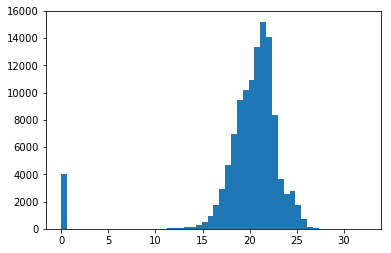

In [15]:
plt.hist(dered_r,52)
plt.show()

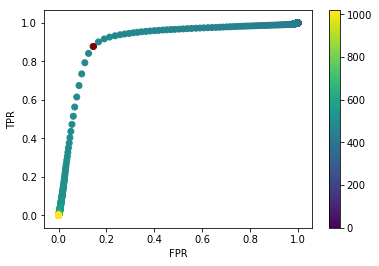

In [56]:
plt.scatter(FPR,TPR,c=[i for i in range(test_range)])

plt.colorbar()
plt.scatter(FPR[np.argmin((TPR-1)**2 + FPR**2)],TPR[np.argmin((TPR-1)**2 + FPR**2)],c=0,cmap='OrRd_r')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [183]:
-5.1+ np.argmin((TPR-1)**2 + FPR**2)*test_accuracy

-0.27999999999999936

In [50]:
A_Object_ID = []
#A_Object_ID = str(A_Object_ID)
for i in range(len(Object_ID)):
    A_Object_ID.append('A'+str(Object_ID[i]))

In [55]:
A_df_r = []
A_df_ID  = []
for i in range(len(df_1)):
    A_df_r.append(df_1['dered_r'][i])
    A_df_ID.append('A'+str(df_1['objID'][i]))

In [57]:
A_df_ID = np.asarray(A_df_ID)
A_df_r = np.asarray(A_df_r)

In [66]:
np.vstack((A_df_ID,A_df_r)).T.shape

(115652, 2)

In [87]:
A_Object_ID=np.asarray(A_Object_ID)

In [86]:
np.savetxt("Adf1.csv",(np.vstack((A_df_ID,A_df_r)).T),delimiter=',',fmt='%s')

In [88]:
np.savetxt("AobjID.csv",A_Object_ID,delimiter=',',fmt='%s')

In [93]:
x_vis[:,0].T


array([-0.39596507, -0.20224622, -0.34136975, ..., -0.22162363,
       -0.50148654, -0.15289032], dtype=float32)

In [94]:
np.savetxt("xvis.csv",x_vis[:,0],delimiter=',',fmt='%s')

In [95]:
LA.shape

(100000,)

In [96]:
LA

array([ 0.,  1.,  0., ...,  1.,  0.,  1.])

In [97]:
np.savetxt("LA.csv",LA,delimiter=',',fmt='%s')

In [104]:
df = pd.read_csv('newmetric.csv',header=None)

In [105]:
df.head()

,0,1,2,3,4,5,6
0,A1237667782837797464,0.0,81,-0.288909,1,1,1
1,A1237667782837797149,0.0,82,-0.257602,1,1,1
2,A1237667782837797418,0.0,83,-0.185216,1,1,1
3,A1237667782837796960,0.0,84,-0.599321,0,0,1
4,A1237667782837796946,0.0,85,-0.580730,0,0,1


In [108]:
df.head()[0]

0    A1237667782837797464
1    A1237667782837797149
2    A1237667782837797418
3    A1237667782837796960
4    A1237667782837796946
Name: 0, dtype: object

In [113]:
np.sum(df[6][df[1]==0])/df[6][df[1]==0].shape[0]

0.9520819563780568

In [157]:
df[6][df[1].map(lambda x: lower_bound_now<x<upper_bound_now)]

3181    1
3182    1
3183    1
3184    1
3185    1
3186    1
3187    1
3188    1
3189    0
3190    1
3191    1
3192    1
3193    1
3194    1
3195    0
3196    1
3197    1
3198    1
3199    1
3200    1
3201    1
3202    1
3203    1
3204    1
3205    1
3206    1
3207    1
3208    0
3209    1
3210    1
       ..
3355    1
3356    1
3357    1
3358    1
3359    1
3360    1
3361    1
3362    1
3363    1
3364    1
3365    1
3366    1
3367    1
3368    1
3369    1
3370    1
3371    1
3372    1
3373    1
3374    1
3375    1
3376    1
3377    1
3378    1
3379    1
3380    1
3381    1
3382    1
3383    1
3384    1
Name: 6, Length: 204, dtype: int64

In [178]:
lower_bound = 13
upper_bound = 26
step_length = 0.5
ticks = []
saveacc = []
Rang = (upper_bound-lower_bound )/step_length
for i in range(int(Rang)):
    lower_bound_now = lower_bound+i*step_length
    upper_bound_now = lower_bound_now + 0.5
    print("range",lower_bound_now,"to",upper_bound_now,"acc",np.sum(df[6][df[1].map(lambda x: lower_bound_now<x<upper_bound_now)])/df[6][df[1].map(lambda x: lower_bound_now<x<upper_bound_now)].shape[0])
    saveacc.append(np.sum(df[6][df[1].map(lambda x: lower_bound_now<x<upper_bound_now)])/df[6][df[1].map(lambda x: lower_bound_now<x<upper_bound_now)].shape[0])
    ticks.append(lower_bound_now)

range 13.0 to 13.5 acc 0.9558823529411765
range 13.5 to 14.0 acc 0.9494584837545126
range 14.0 to 14.5 acc 0.9473684210526315
range 14.5 to 15.0 acc 0.9506172839506173
range 15.0 to 15.5 acc 0.9368421052631579
range 15.5 to 16.0 acc 0.9589442815249267
range 16.0 to 16.5 acc 0.9475164011246485
range 16.5 to 17.0 acc 0.9462219196732471
range 17.0 to 17.5 acc 0.9514925373134329
range 17.5 to 18.0 acc 0.9505112474437628
range 18.0 to 18.5 acc 0.942431901151362
range 18.5 to 19.0 acc 0.9471731063086662
range 19.0 to 19.5 acc 0.9483516483516483
range 19.5 to 20.0 acc 0.947136563876652
range 20.0 to 20.5 acc 0.9487215119510839
range 20.5 to 21.0 acc 0.9501853788382926
range 21.0 to 21.5 acc 0.9485144266866888
range 21.5 to 22.0 acc 0.9461997542566263
range 22.0 to 22.5 acc 0.9441955590183093
range 22.5 to 23.0 acc 0.9525261324041812
range 23.0 to 23.5 acc 0.9475046210720888
range 23.5 to 24.0 acc 0.9489971346704871
range 24.0 to 24.5 acc 0.9539227895392279
range 24.5 to 25.0 acc 0.94353963083

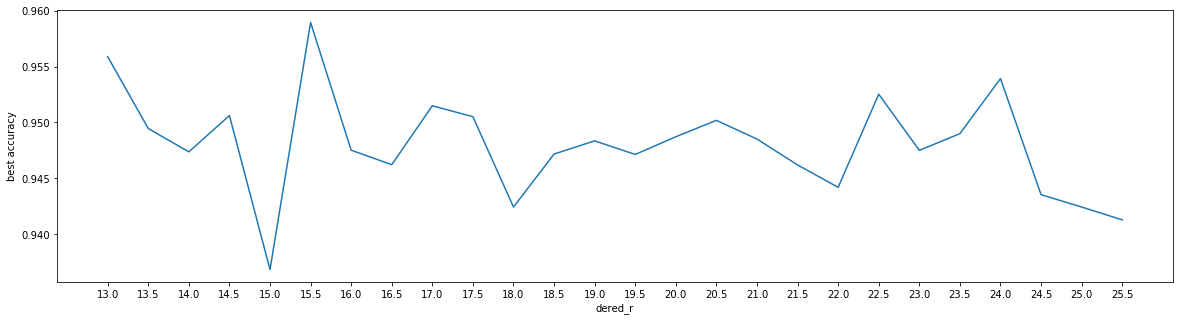

In [182]:
plt.figure(figsize=(20, 5))
plt.plot(saveacc)
plt.xticks(range(int(Rang)),ticks)
plt.xlabel("dered_r")
plt.ylabel("best accuracy")